# Part 1 ‑ Exploratory data analysis

In [3]:
# Importing Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
logins_df = pd.read_json('logins.json')

In [5]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins_df.shape

(93142, 1)

In [7]:
logins_df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [8]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [9]:
#adding count column for resample
logins_df['count'] = 1
logins_df.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [10]:
# Setting index as login time 
logins_df.set_index('login_time', inplace=True)

In [11]:
# resample the data based on 15 min interval
df_sampled = logins_df.resample("15T").agg('sum')
df_sampled.reset_index(inplace=True)
df_sampled.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Logins at 15 min increments')

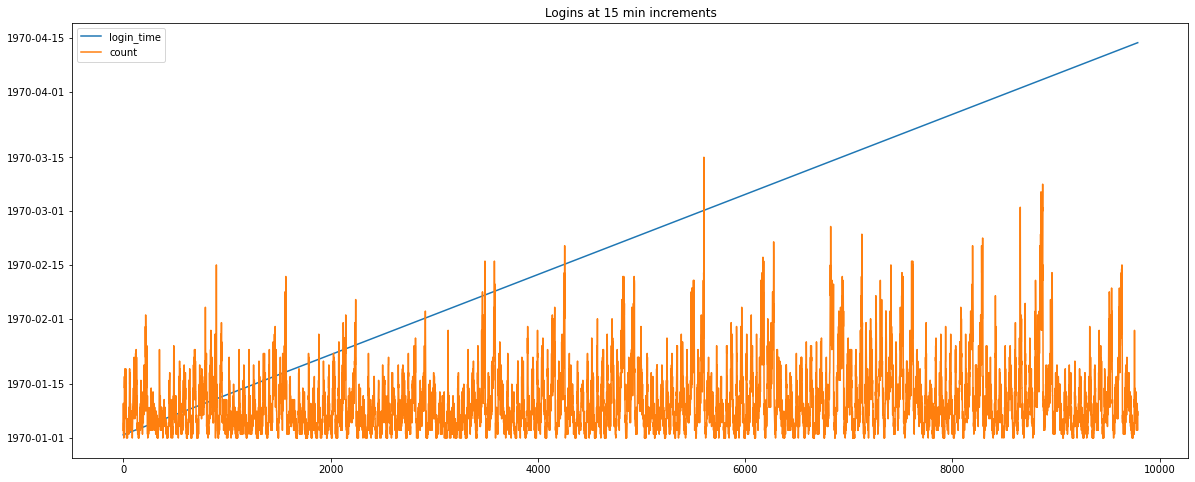

In [12]:
df_sampled.plot(kind="line", figsize=(20, 8))
plt.title("Logins at 15 min increments")

Plotting the 15 minute intervals over the 4 month period, we can see a sinusoidal pattern that seems to have an average value that is increasing. There are some spikes. 

In [13]:
# Creating new columns
df_sampled['year'] = df_sampled['login_time'].dt.year
df_sampled['month'] = df_sampled['login_time'].dt.month
df_sampled['day'] = df_sampled['login_time'].dt.day
df_sampled['hour'] = df_sampled['login_time'].dt.hour
df_sampled['min'] = df_sampled['login_time'].dt.minute
df_sampled['data'] = df_sampled['login_time'].dt.date
df_sampled['time'] = df_sampled['login_time'].dt.time
df_sampled['weekday']= df_sampled['login_time'].dt.day_name()
df_sampled['week']= df_sampled['login_time'].dt.week

<ipython-input-13-90824bc51a73>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_sampled['week']= df_sampled['login_time'].dt.week


In [14]:
df_sampled.head()

,login_time,count,year,month,day,hour,min,data,time,weekday,week
0,1970-01-01 20:00:00,2,1970,1,1,20,0,1970-01-01,20:00:00,Thursday,1
1,1970-01-01 20:15:00,6,1970,1,1,20,15,1970-01-01,20:15:00,Thursday,1
2,1970-01-01 20:30:00,9,1970,1,1,20,30,1970-01-01,20:30:00,Thursday,1
3,1970-01-01 20:45:00,7,1970,1,1,20,45,1970-01-01,20:45:00,Thursday,1
4,1970-01-01 21:00:00,1,1970,1,1,21,0,1970-01-01,21:00:00,Thursday,1


[Text(0.5, 1.0, 'Logins per Day of Week')]

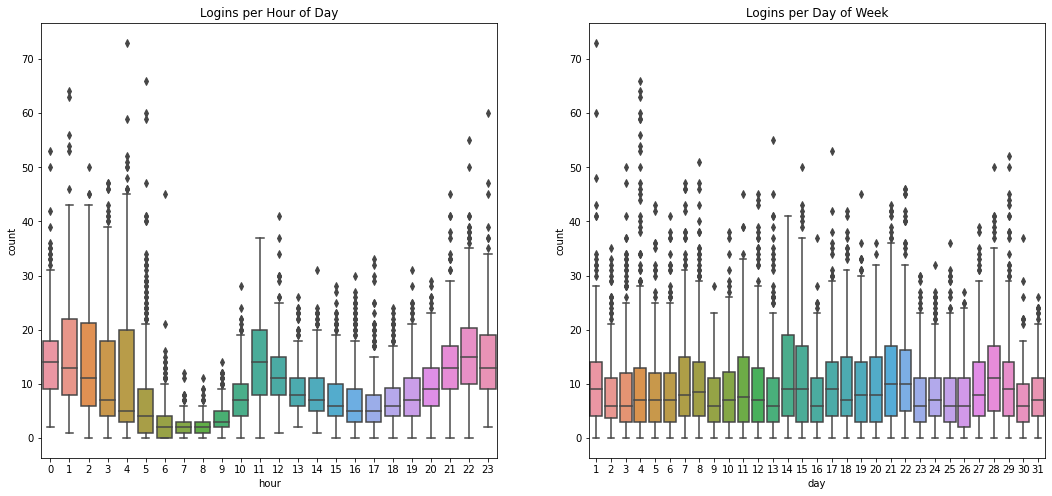

In [33]:
fig, axs = plt.subplots(ncols=2, figsize=(18,8))
sns.boxplot(data=df_sampled, x='hour', y='count', ax=axs[0]).set(title = 'Logins per Hour of Day' )
sns.boxplot(data=df_sampled, x='day', y='count', ax=axs[1]).set(title = 'Logins per Day of Week')

<AxesSubplot:title={'center':'Login Count by Day of Week'}, xlabel='weekday'>

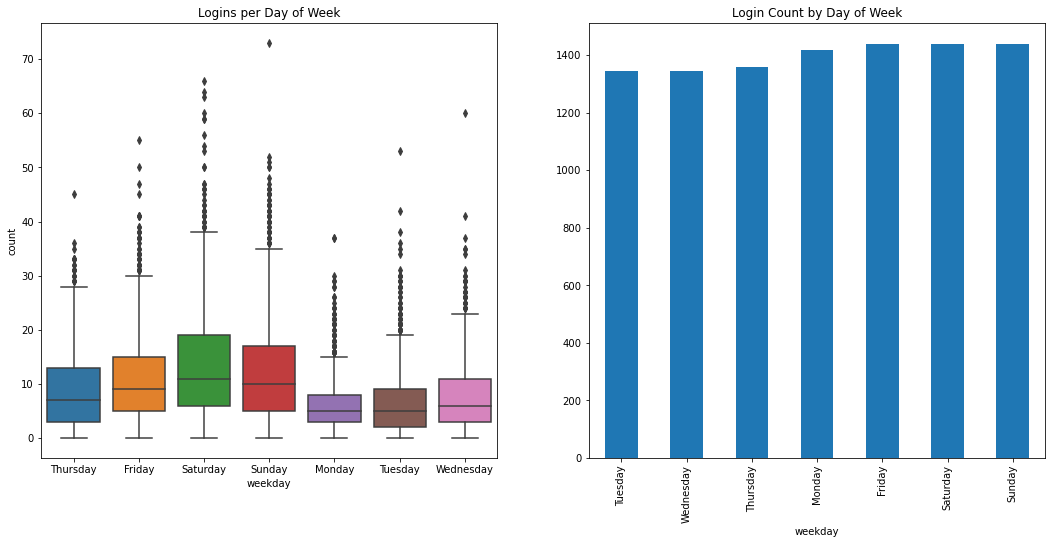

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(18,8))
sns.boxplot(data=df_sampled, x='weekday', y='count', ax=axs[0] ).set(title = 'Logins per Day of Week')
df_sampled.groupby(['weekday'])['weekday'].count().sort_values().plot(kind='bar', title="Login Count by Day of Week")

<AxesSubplot:title={'center':'Login Count by Week of Year'}, xlabel='week'>

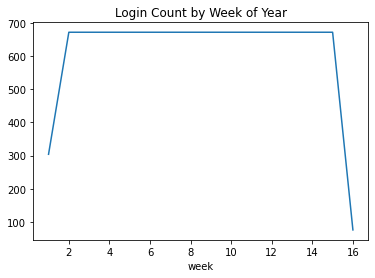

In [50]:
df_sampled.groupby(['week'])['day'].count().plot(title="Login Count by Week of Year")

<AxesSubplot:title={'center':'Login Count by Time'}, xlabel='time'>

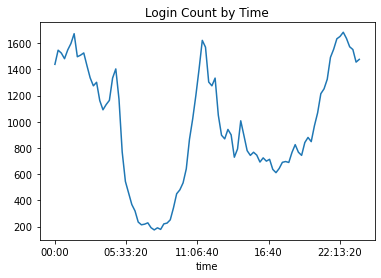

In [51]:
df_sampled.groupby(['time'])['count'].sum().plot(title = "Login Count by Time")

Result:
The number of trips have slight increase through the months. The general trend is same.  There are two peaks in a day. Around Morning 11 and in late evening
We can see from these plots the patterns over the hours of the day and the days of the week. 

# Part 2 ‑ Experiment and metrics design

The key metric should be the change in weekday activity. Here we have to check during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham AND during the night is there an increase of cars entering the bridge from Metropolis. We can keep the record of cars crossing tht toll bridge and make reubersment process faster.

we conduct a z-test, assuming sample size > 30 drivers. Compare number driver bridge crossings.

Null hypothesis: No difference in driver bridge crossings, after toll reimbursement experiment. 
Null hypothesis will be rejected if there is increase in driver bridge crossings, after toll reimbursement experiment. Null hypothesis distribution is simply the distribution of driver crossings before toll reimbursement experiment.

Calculate z-score of average frequency of drivers serving both cities, post-reimbursement experiment. Set p=0.05. Determine if z-score's p-value falls below this significance threshold.

If p-value < 0.05, we will reject the null hypothesis. The result would support a significant increase in driver bridge crossings after the toll reimbursement is introduced, indicating that this policy was a success.

However, the  significance levels are set arbitrarly and p-values fluctuate depending on sample size. So depending on how wide of a margin the post-reimbursement increase is, our experiment could either support or reject the policy.

As a result, I recommend only considering the policy a success if the margin is wide enough (and p-value far below 0.05). 

In [52]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')

In [53]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [54]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
#drop rows with no phone information
ultimate_df = ultimate_df.drop(ultimate_df[ultimate_df.phone.isna()==True].index,axis=0)
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [24]:
#fill missing values by mean values of the column avg_rating_of_driver and avg_rating_by_driver
ultimate_df.avg_rating_by_driver.fillna(ultimate_df.avg_rating_by_driver.mean(),inplace=True)
ultimate_df.avg_rating_of_driver.fillna(ultimate_df.avg_rating_of_driver.mean(),inplace=True)

In [25]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [26]:
#converting 'last_trip_date' column from object type to timestamp
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [27]:
#set current date 
current_date = ultimate_df['last_trip_date'].max()

#find if user qualifies as active
ultimate_df['active'] = ultimate_df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [28]:
ultimate_df['active'].value_counts()

0    30933
1    18671
Name: active, dtype: int64

In [29]:
#percentage of drivers who are active 
18671/49604*100

37.640109668575114

Random Forest Classifier will be employed since it is powerful for prediction and will give us insight into the importance of the features.

In [30]:
df_features = pd.get_dummies(ultimate_df,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [31]:
#set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

In [32]:
df_features.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [34]:
#scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [35]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)

In [36]:
#build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [37]:
rf.score(X_test,y_test)

0.7501259953633707

In [38]:
cv_score=cross_val_score(rf,X_test,np.ravel(y_test),cv=5)
print('Mean Cross Validated Score:',np.mean(cv_score))

Mean Cross Validated Score: 0.7501255890956366


In [39]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.299760
4,weekday_pct,0.133660
6,avg_rating_by_driver,0.113260
1,avg_rating_of_driver,0.081902
0,trips_in_first_30_days,0.080028
3,surge_pct,0.078103
2,avg_surge,0.067124
8,city_King's Landing,0.046687
11,phone_iPhone,0.019893
10,phone_Android,0.019774


City, phone type, and ultimate black user stats are all relatively unimportant for the model compared to average distance driven, weekday percentage, and the rating given to the passenger by the driver

In [40]:
#generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[4969, 1231],
       [1248, 2473]], dtype=int64)

# Logistc Regression with Grid Search

In [41]:
#initialize model
logit = LogisticRegression(solver='lbfgs')
#set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [42]:
grid.best_estimator_.C

3.999999999999999

In [43]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef

,feature,coefficient
0,trips_in_first_30_days,0.113437
1,avg_rating_of_driver,-0.329943
2,avg_surge,2.509991
3,surge_pct,-1.430471
4,weekday_pct,-0.242662
5,avg_dist,0.157505
6,avg_rating_by_driver,-1.345031
7,city_Astapor,-0.770335
8,city_King's Landing,1.114930
9,city_Winterfell,-0.249246


In [44]:
print(np.mean(cross_val_score(grid,X_test,np.ravel(y_test),cv=5)))

0.7420622917851629


Both the models perform almost same.

In conclusion, we have extracted very valuable information from this dataset.

First, we have built a predictive model with 75% accuracy, that will be useful for future prediction.

Secondly,  Random Forest gave the most important features and Logistic Regression shows us the effect of the features through the coefficients. Taking the three most important features, we can see the following effects on the "activity" of a rider after 6 months.These insights from the model are very important for the company.

Average distance: This one is tricky because while our logistic regression model shows that an increase in average distance per trip in the first 30 days increases our chances of being an active user. But the mean avg_dist is larger for inactive riders than for active. It may not be advisable to try to increase the distance of trips taken in the first 30 days.

weekday percentage: The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app by giving incentives on the weekend will be beneficial for the company revenue.

average rating by driver: There is a decreased chance of being an active user as your rating goes up.

trips in the first 30 days: As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months. The company can offer incentives to take more trips during their first 30 days on the app.

Based on these insights gained from the model, these are several recomendations for the company.